<a href="https://colab.research.google.com/github/mseo12/object_detection_demo/blob/master/tensorflow_Catption_Detection_training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train an object detection model easy for free](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) | DLology Blog

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [49]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/mseo12/object_detection_demo'

# Number of training steps.
num_steps = 1000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 100
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `object_detection_demo` repository or your fork.

In [52]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
fatal: destination path 'object_detection_demo' already exists and is not an empty directory.
/content/object_detection_demo
Already up to date.


## Install required packages

In [53]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-tk

!pip install -q gast Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools tf_slim lvis

!pip install tensorflow==1.15.0

!git clone https://github.com/tensorflow/models.git

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/:/content/models/research/:/content/models/research/slim/'

import sys
sys.path.append("/content/models")

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research


In [54]:
%cd {repo_dir_path}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python xml_to_csv.py -i /content/drive/MyDrive/data/images/train -o /content/drive/MyDrive/data/annotations/train_labels.csv -l /content/drive/MyDrive/data/annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py -i /content/drive/MyDrive/data/images/test -o /content/drive/MyDrive/data/annotations/test_labels.csv

# Generate `train.record`
!python generate_tfrecord.py --csv_input=/content/drive/MyDrive/data/annotations/train_labels.csv --output_path=/content/drive/MyDrive/data/annotations/train.record --img_path=/content/drive/MyDrive/data/images/train --label_map /content/drive/MyDrive/data/annotations/label_map.pbtxt

# Generate `test.record`
!python generate_tfrecord.py --csv_input=/content/drive/MyDrive/data/annotations/test_labels.csv --output_path=/content/drive/MyDrive/data/annotations/test.record --img_path=/content/drive/MyDrive/data/images/test --label_map /content/drive/MyDrive/data/annotations/label_map.pbtxt

/content/object_detection_demo
Successfully converted xml to csv.
Generate `/content/drive/MyDrive/data/annotations/label_map.pbtxt`
Successfully converted xml to csv.
Successfully created the TFRecords: /content/drive/MyDrive/data/annotations/train.record
Successfully created the TFRecords: /content/drive/MyDrive/data/annotations/test.record


## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.
```bash
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt
```

In [84]:
test_record_fname = '/content/drive/MyDrive/data/annotations/test.record'
train_record_fname = '/content/drive/MyDrive/data/annotations/train.record'
label_map_pbtxt_fname = '/content/drive/MyDrive/data/annotations/label_map.pbtxt'

## Download base model

In [70]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [85]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 476M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 25 root   root 4.0K Jan  7 00:19 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000 208M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000 262M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  26K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 6.4M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.1K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [86]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [87]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [88]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [89]:
import re

label_map_pbtxt_fname = os.path.join('/content/drive/MyDrive/data/annotations/', 'label_map.pbtxt')
train_record_fname = os.path.join('/content/drive/MyDrive/data/annotations/', 'train.record')
test_record_fname = os.path.join('/content/drive/MyDrive/data/annotations/', 'test.record')

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [90]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [91]:
model_dir = '/content/models/research/training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [92]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-01-07 00:30:16--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.100.2, 3.213.223.141, 54.198.148.204, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.100.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  18.7MB/s    in 0.7s    

2021-01-07 00:30:17 (18.7 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [93]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [94]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [95]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://10dc9f58962e.ngrok.io


## Train the model

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0107 00:30:39.477870 140169131386752 model_lib.py:793] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 1000
I0107 00:30:39.478092 140169131386752 config_util.py:552] Maybe overwriting train_steps: 1000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0107 00:30:39.478193 140169131386752 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0107 00:30:39.478286 140169131386752 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0107 00:30:39.478375 140169131386752 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0107 00:30:39.478483 140169131386752 model_lib.py:809] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

In [65]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1609974388.5947943095bc
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta


In [ ]:
# Legacy way of training(also works).
# !python /content/models/research/object_detection/legacy/train.py --logtostderr --train_dir={model_dir} --pipeline_config_path={pipeline_fname}

## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [25]:
import re
import numpy as np

output_directory = '/content/drive/MyDrive/data/fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/models/research/training/model.ckpt-1000
Instructions for updating:
Please use `layer.__call__` method instead.
W0106 23:18:21.958373 139683175290752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0106 23:18:23.831192 139683175290752 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0106 23:18:23.866292 139683175290752 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0106 23:18:23.900454 139683175290752 convolutional_box_predictor.py:156] depth of additional conv before box predicto

In [67]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [28]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [29]:
!ls -alh {pb_fname}

-rw------- 1 root root 19M Jan  6 23:18 /content/drive/MyDrive/data/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [30]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 191jDqru3hZ0CnlvLj00cGIyJ9METPTVL


### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [31]:
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download the `label_map.pbtxt` file

In [32]:
from google.colab import files
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [33]:
files.download(pipeline_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [68]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join("/content/drive/MyDrive/data/inference/", "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/drive/MyDrive/data/inference/test/GOLF_27.jpeg']


/content/models/research/object_detection
[0.41483828 0.41466504 0.41357213 0.41279906 0.41198188 0.4112072
 0.41032976 0.40916964 0.40756378 0.4071111  0.4067918  0.40454474
 0.39543012 0.394724   0.3921481  0.39159065 0.39005738 0.38989335
 0.3898403  0.38923243 0.38779953 0.38753226 0.38702    0.38639137
 0.38586485 0.3851848  0.38510814 0.38444388 0.38375714 0.3820945
 0.38091162 0.38066176 0.38016045 0.3799161  0.3794029  0.37840325
 0.37704834 0.37617683 0.3757615  0.37384996 0.3690528  0.3140279
 0.31324852 0.31290153 0.31275365 0.31050485 0.3046401  0.30456433
 0.30437773 0.30419236 0.30315322 0.30307007 0.30108774 0.30050814
 0.3003791  0.29983288 0.2997276  0.2993242  0.29893932 0.29875052
 0.29861706 0.29846346 0.29802442 0.29784936 0.2976779  0.2971114
 0.29687667 0.29682308 0.29643846 0.2962098  0.2905047  0.29010418
 0.28987646 0.28986424 0.28928626 0.2880985  0.2880898  0.28783423
 0.28765786 0.2870473  0.28692007 0.28690517 0.2868561  0.2858114
 0.2857519  0.28555238 0.

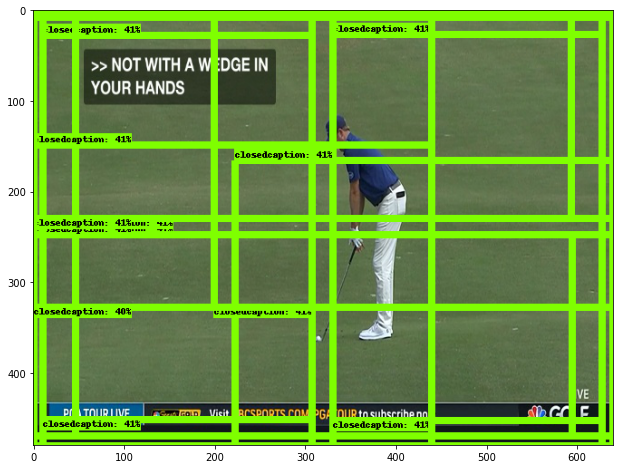

In [69]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8,
        min_score_thresh=0.5)
    print(output_dict['detection_scores'])
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)